In [1]:
import os
from os.path import join
import glob
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nilearn
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator


from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn import plotting
from nilearn.plotting import plot_design_matrix
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.reporting import make_glm_report


/Users/RaulAlvarez/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Signal the directory where dataset is located
data_dir = 'Localizer'
layout = BIDSLayout(data_dir, derivatives=True)

#Getting the 'tr'
tr = layout.get_tr()
print(tr)

/Users/RaulAlvarez/opt/anaconda3/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


2.4


In [11]:
# Setting up a folder where to store the 'computed contrasts files' 
outdir = 'Localizer/results2'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [3]:
# Number of participants for the analysis
n_subjects = 40
subjects_label = ['sub-S%02d' % i for i in range(1, n_subjects + 1)]

# Loading participants info
participants_info = pd.read_csv("Localizer/participants.tsv", sep='\t')
participants_info = participants_info[['participant_id', 'age', 'sex']] 

# Renaming 'participant_id' for 'subject_label'
# Required by Nilearn for 'make_second_level_design_matrix'
participants_info.columns = ['subject_label', 'age', 'sex']

# Fixing a 'Nan' entry in participant 37
participants_info = participants_info[0:40]
participants_info.age[37] = np.round(np.mean(participants_info.age))

# Creating 'DataFrame' with variables (id, age, sex) for SecondLevel analysis
for x in range(len(participants_info.subject_label)):
        name = "sub-S"
        if(x < 9):
            name = name + "0"
        
        name = name + (str(x + 1))
        participants_info.subject_label[x] = name
        
        if(participants_info.sex[x] == "M"):
            participants_info.sex[x] = 1
        else:
            participants_info.sex[x] = 0
        
participants_info.head()

<ipython-input-3-a71fcb2195c8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_info.subject_label[x] = name
<ipython-input-3-a71fcb2195c8>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_info.sex[x] = 1
<ipython-input-3-a71fcb2195c8>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_info.sex[x] = 0


,subject_label,age,sex
0,sub-S01,24.0,1
1,sub-S02,20.0,1
2,sub-S03,22.0,0
3,sub-S04,20.0,1
4,sub-S05,23.0,0


<ipython-input-4-48e3cbc22d8e>:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


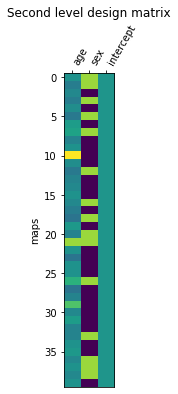

In [4]:
# Creating Design Matrix for SecondLevel Analysis
design_matrix = make_second_level_design_matrix(subjects_label, participants_info)

# Access 'design_matrix' variables
second_glm_contrast_intercept = np.array([0, 0, 1])
second_glm_contrast_sex = np.array([0, 1, 1])
second_glm_contrast_age = np.array([1, 0, 1])

# Plotting Matrix
ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('maps')
plt.tight_layout()
plt.show()

In [6]:
# Loading data
subs_num = 40

# Store string/path to each participants file
#subs_data = []

# Store concatonated data in a nibabel.Nifti1Image object
fmri_data = []
path = "Localizer/derivatives/fmriprep/"
func1 = "/func/"
func2 = "_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

# Store events data for each participant
events_data = []

# Store confounds data for each participant
confounds_data = []
c_path = "_task-localizer_desc-confounds_regressors.tsv"

for x in range(subs_num):
    
    # Getting right each participants' name 
    name = "sub-S"
    if(x < 9):
        name = name + "0"
    name = name + (str(x + 1))
    
    # Extract and concat pre-processed fmri data
    fmri_data.append(concat_imgs(str(path + name + func1 + name + func2)))
    
    # Extract events data
    e_name = name[4:]
    events_data.append(pd.read_csv(layout.get(subject=e_name, suffix='events')[0].path, sep='\t'))
    
    # Extract confounds data
    holder = str(path + name + func1 + name + c_path)
    holder = pd.read_csv(holder, delimiter='\t')
    holder = holder.fillna(0)
    confounds_data.append(holder[['white_matter', 'global_signal','framewise_displacement', 'csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']])


In [7]:
# Creating FirstLevelModel objects
fmri_glm = FirstLevelModel(t_r=tr,
                           drift_model='cosine',
                           high_pass=0.007,
                           standardize=False,
                           hrf_model='spm + derivative',
                           slice_time_ref=0.5,
                           smoothing_fwhm=5)


In [8]:
# Function to access FirstLevel GLM contrasts

def make_localizer_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # Generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    # Contrast adding all conditions involving 'audio'
    contrasts['audio'] = (
        contrasts['audio_left_hand']
        + contrasts['audio_right_hand']
        + contrasts['audio_computation']
        + contrasts['audio_sentence'])

    # Contrast adding all conditions involving 'video'
    contrasts['video'] = (
        contrasts['video_left_hand']
        + contrasts['video_right_hand']
        + contrasts['video_computation']
        + contrasts['video_sentence'])

    # Contrast adding all conditions involving 'computation'
    contrasts['computation'] = (contrasts['video_computation']
                                + contrasts['audio_computation'])

    # Contrast adding all conditions involving 'sentence'
    contrasts['sentences'] = (contrasts['audio_sentence']
                              + contrasts['video_sentence'])

    # Short dictionary of more relevant contrasts
    contrasts = {
        'left - right button press': (
            contrasts['audio_left_hand']
            - contrasts['audio_right_hand']
            + contrasts['video_left_hand']
            - contrasts['video_right_hand']
        ),
        'right - left button press': (
            - contrasts['audio_left_hand']
            + contrasts['audio_right_hand']
            - contrasts['video_left_hand']
            + contrasts['video_right_hand']
        ),
        
        'audio - video': contrasts['audio'] - contrasts['video'],
        'computation - sentences': (contrasts['computation'] -
                                    contrasts['sentences']
        ),
        'horizontal-vertical': (contrasts['horizontal_checkerboard'] -
                                contrasts['vertical_checkerboard']),
        'audio': contrasts['audio'], 
        'video': contrasts['video'],
        'computation': contrasts['sentences'],
        'sentences': contrasts['sentences'],
        'mov_left': (contrasts['audio_left_hand'] + contrasts['video_left_hand']),
        'mov_right': (contrasts['audio_right_hand'] + contrasts['video_right_hand']),
    }
    return contrasts



In [9]:
# Creating a first glm demo
# Required to creat a first_glm_contrast and access all contrasts defined
demo_first_glm = fmri_glm.fit(fmri_data[0], events_data[0], confounds=confounds_data[0])

# Creating FirstLevel Design Matrix 
first_glm_contrast = demo_first_glm.design_matrices_[0]

# Var to access FirstLevel contrasts
first_glm_contrast = make_localizer_contrasts(first_glm_contrast)


In [30]:
# Dictionary storing object (fitted data to the GLM object)
first_glm_data = []

for x in range(subs_num):
    
    # Getting participants name/string right
    name = "sub-S"
    if(x < 9):
        name = name + "0"
    name = name + (str(x + 1))
    e_name = name[4:]
    
    
    #first_glm_data.append(fmri_glm.fit(fmri_data[x], events_data[x], confounds=confounds_data[x]))
    fmri_glm.fit(fmri_data[x], events_data[x], confounds=confounds_data[x])
    
    # Getting and storing fitted object w/ audio contrast
    z_map = fmri_glm.compute_contrast(first_glm_contrast['audio'], output_type='z_score')
    
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-localizer_space-MNI152nlin2009casym_desc-audio_zmap.nii.gz' %e_name))
    
    # Getting and storing fitted object w/ video contrast
    z_map = fmri_glm.compute_contrast(first_glm_contrast['video'], output_type='z_score')
    
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-localizer_space-MNI152nlin2009casym_desc-video_zmap.nii.gz' %e_name))
    
    # Getting and storing fitted object w/ mov_left contrast
    z_map = fmri_glm.compute_contrast(first_glm_contrast['mov_left'], output_type='z_score')
    
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-localizer_space-MNI152nlin2009casym_desc-mov_left_zmap.nii.gz' %e_name))
    
    # Getting and storing fitted object w/ mov_right contrast
    z_map = fmri_glm.compute_contrast(first_glm_contrast['mov_right'], output_type='z_score')
    
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-localizer_space-MNI152nlin2009casym_desc-mov_right_zmap.nii.gz' %e_name))
    
    # Getting and storing fitted object w/ computation contrast
    z_map = fmri_glm.compute_contrast(first_glm_contrast['computation'], output_type='z_score')
    
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-localizer_space-MNI152nlin2009casym_desc-computation_zmap.nii.gz' %e_name))

    # Getting and storing fitted object w/ sentence contrast
    z_map = fmri_glm.compute_contrast(first_glm_contrast['sentences'], output_type='z_score')
    
    z_map.to_filename(join(outdir, 'sub-%s_ses-test_task-localizer_space-MNI152nlin2009casym_desc-sentences_zmap.nii.gz' %e_name))

In [37]:
# Creating lists for each of the computed contrasts'
list_z_maps_audio = glob(join(outdir, 'sub-*_ses-test_task-localizer_space-MNI152nlin2009casym_desc-audio_zmap.nii.gz'))
list_z_maps_video = glob(join(outdir, 'sub-*_ses-test_task-localizer_space-MNI152nlin2009casym_desc-video_zmap.nii.gz'))
list_z_maps_mov_right = glob(join(outdir, 'sub-*_ses-test_task-localizer_space-MNI152nlin2009casym_desc-mov_right_zmap.nii.gz'))
list_z_maps_mov_left = glob(join(outdir, 'sub-*_ses-test_task-localizer_space-MNI152nlin2009casym_desc-mov_left_zmap.nii.gz'))
list_z_maps_computation = glob(join(outdir, 'sub-*_ses-test_task-localizer_space-MNI152nlin2009casym_desc-computation_zmap.nii.gz'))
list_z_maps_sentences = glob(join(outdir, 'sub-*_ses-test_task-localizer_space-MNI152nlin2009casym_desc-sentences_zmap.nii.gz'))



In [13]:
# Getting mask for plotting results
path = "Localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
fmri_img = concat_imgs(path)
mean_img = mean_img(fmri_img)
mean_img.shape


(91, 109, 91)

# Audio Group Activity

In [14]:
# Creating SecondLevel model object w/ 8 spatial smoothing 
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
# Fitting the (z_maps_audio) to the SecondLevel model
second_level_model_audio = second_level_model.fit(list_z_maps_audio, design_matrix=design_matrix) 


In [15]:
# Getting raw results (z_map_group_audio), clean results (clean_map), and a thresold to plot the restults
z_map_group_audio = second_level_model_audio.compute_contrast(second_level_contrast=second_glm_contrast_intercept, output_type='z_score')

# Get clean map (only plotting clusteres > 10) and using a threshold (false discovery rate = 0.05%)
clean_map, threshold = threshold_stats_img(z_map_group_audio, alpha=.05, height_control='fdr', cluster_threshold=10)


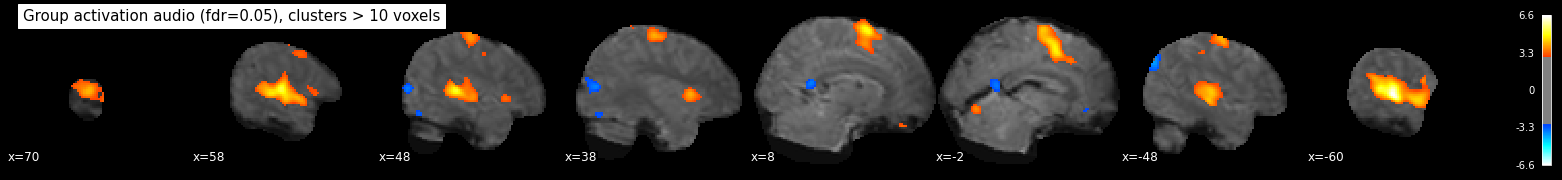

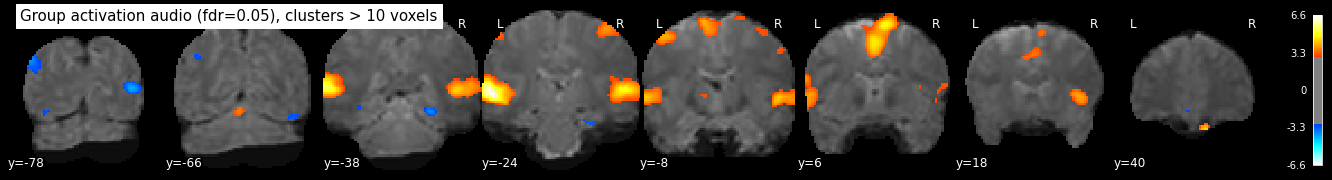

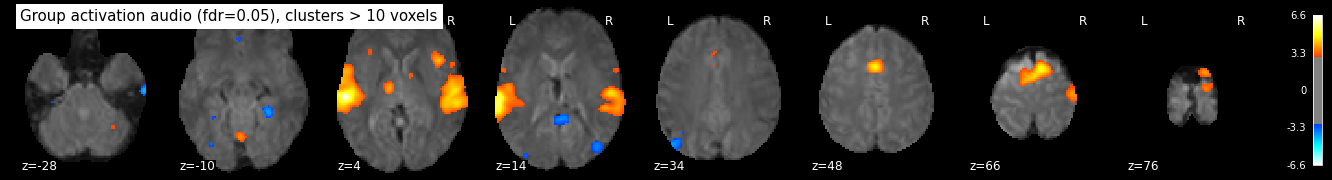

In [16]:
# Plotting results

dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Group activation audio (fdr=0.05), clusters > 10 voxels') 
    plt.show()


In [17]:
report_audio = make_glm_report(second_level_model_audio,
                         contrasts='intercept',
                         bg_img=mean_img
                         )

# Video Group Activity

In [67]:
# Fitting the (z_maps_video) to the SecondLevel model
second_level_model_video = second_level_model.fit(list_z_maps_video, design_matrix=design_matrix) 


In [68]:
# Getting raw results (z_map_group_video), clean results (clean_map), and a thresold to plot the restults
z_map_group_video = second_level_model_video.compute_contrast(second_level_contrast=second_glm_contrast_intercept, output_type='z_score')

# Get clean map (only plotting clusteres > 10) and using a threshold (false discovery rate = 0.10%)
clean_map, threshold = threshold_stats_img(z_map_group_video, alpha=.10, height_control='fdr', cluster_threshold=10)


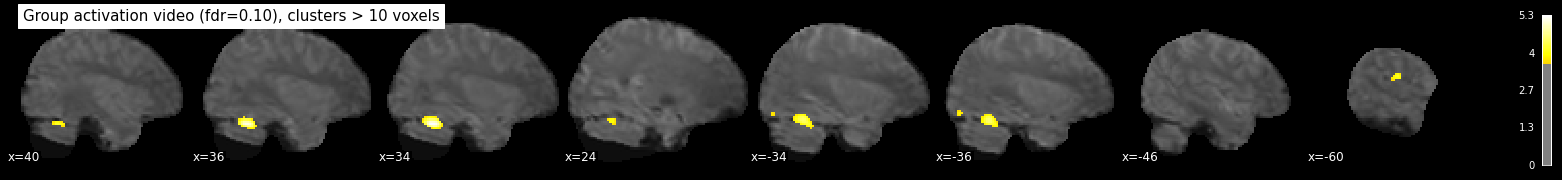

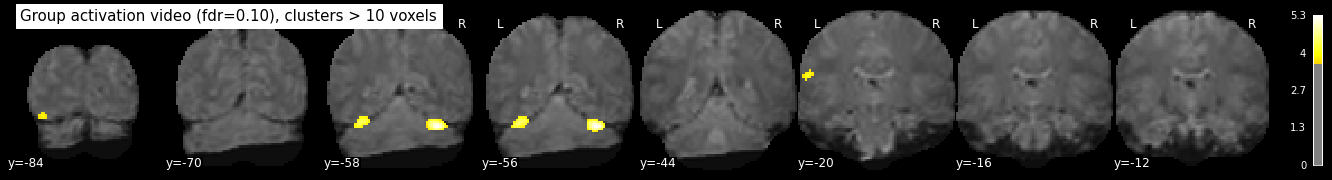

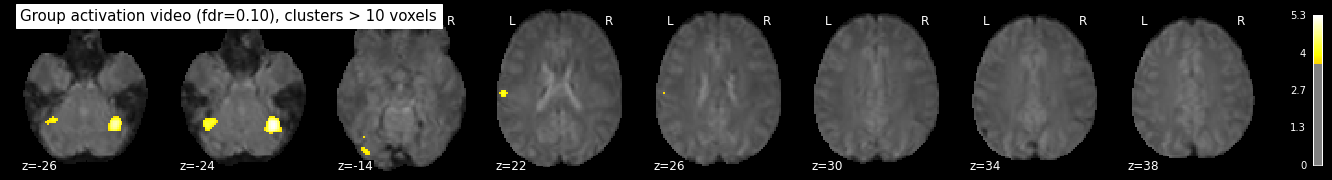

In [69]:
# Plotting results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Group activation video (fdr=0.10), clusters > 10 voxels') 
    plt.show()

In [70]:
report_video = make_glm_report(second_level_model_video,
                         contrasts='intercept',
                         bg_img=mean_img
                         )

# Mov_right Group Activity

In [82]:
# Fitting the (z_maps_mov_right) to the SecondLevel model
second_level_model_mov_right = second_level_model.fit(list_z_maps_mov_right, design_matrix=design_matrix) 


In [83]:
# Getting raw results (z_map_group_video), clean results (clean_map), and a thresold to plot the restults
z_map_group_mov_right = second_level_model_video.compute_contrast(second_level_contrast=second_glm_contrast_intercept, output_type='z_score')

# Get clean map (only plotting clusteres > 10) and using a threshold (false discovery rate = 0.5%)
clean_map, threshold = threshold_stats_img(z_map_group_mov_right, alpha=.05, height_control='fdr', cluster_threshold=10)


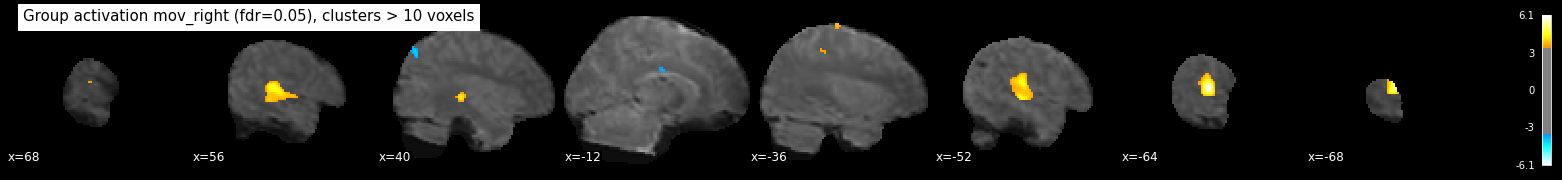

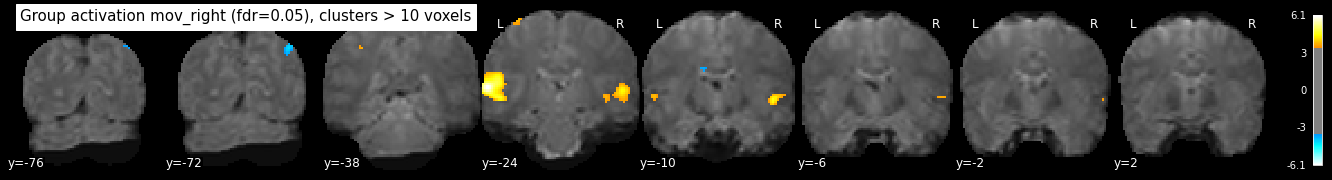

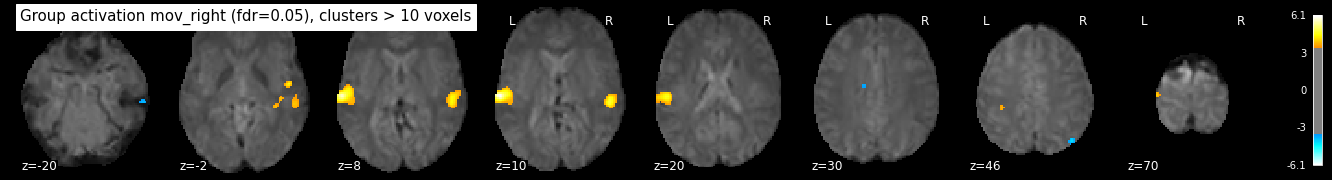

In [84]:
# Plotting results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Group activation mov_right (fdr=0.05), clusters > 10 voxels') 
    plt.show()

In [85]:
report_mov_right = make_glm_report(second_level_model_mov_right,
                         contrasts='intercept',
                         bg_img=mean_img
                         )

# Mov_left Group Activity

In [75]:
second_level_model_mov_left = second_level_model.fit(list_z_maps_mov_left, design_matrix=design_matrix)

In [78]:
# Getting raw results (z_map_group_video), clean results (clean_map), and a thresold to plot the restults
z_map_group_mov_left = second_level_model_mov_left.compute_contrast(second_level_contrast=second_glm_contrast_intercept, output_type='z_score')

# Get clean map (only plotting clusteres > 10) and using a threshold (false discovery rate = 0.5%)
clean_map, threshold = threshold_stats_img(z_map_group_mov_left, alpha=.08, height_control='fdr', cluster_threshold=10)


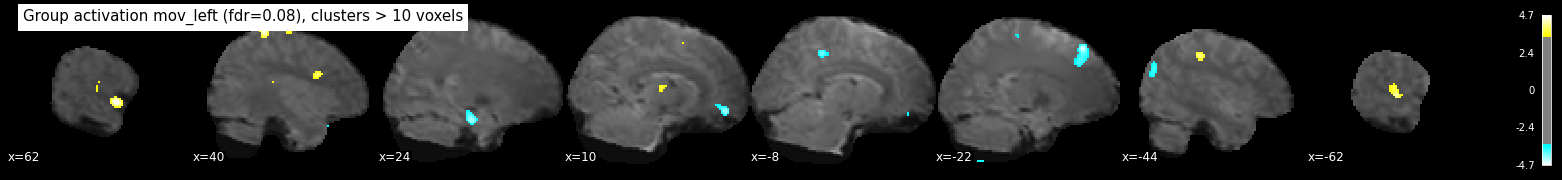

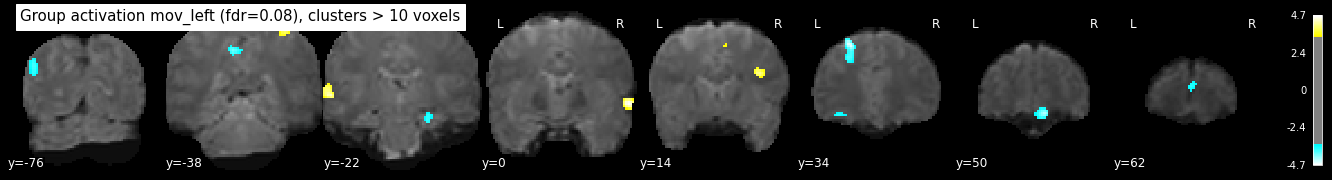

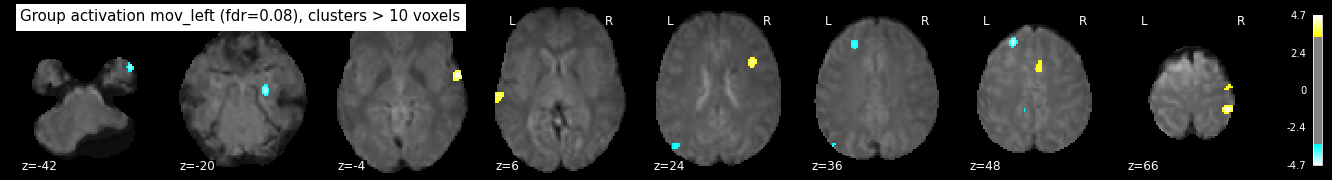

In [80]:
# Plotting results
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Group activation mov_left (fdr=0.08), clusters > 10 voxels') 
    plt.show()

In [81]:
report_mov_left = make_glm_report(second_level_model_mov_left,
                         contrasts='intercept',
                         bg_img=mean_img
                         )

# Computation Group Activity

In [86]:
second_level_model_computation = second_level_model.fit(list_z_maps_computation, design_matrix=design_matrix)

In [87]:
# Getting raw results (z_map_group_video), clean results (clean_map), and a thresold to plot the restults
z_map_group_computation = second_level_model_computation.compute_contrast(second_level_contrast=second_glm_contrast_intercept, output_type='z_score')

# Get clean map (only plotting clusteres > 10) and using a threshold (false discovery rate = 0.5%)
clean_map, threshold = threshold_stats_img(z_map_group_computation, alpha=.10, height_control='fdr', cluster_threshold=10)


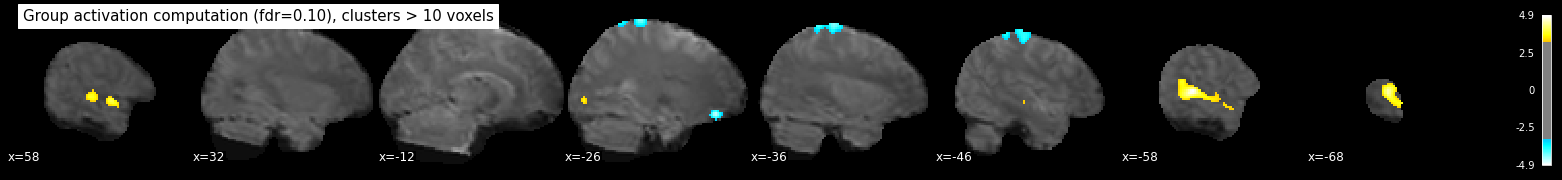

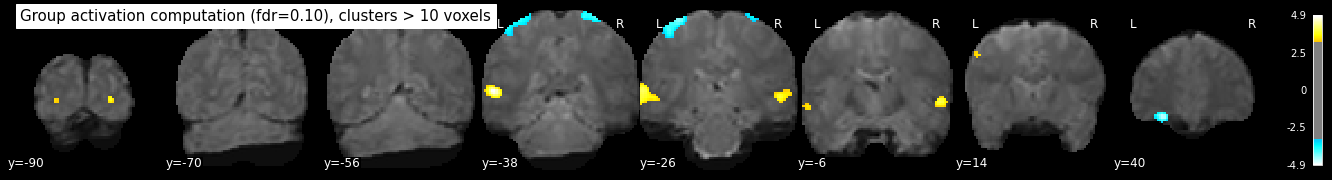

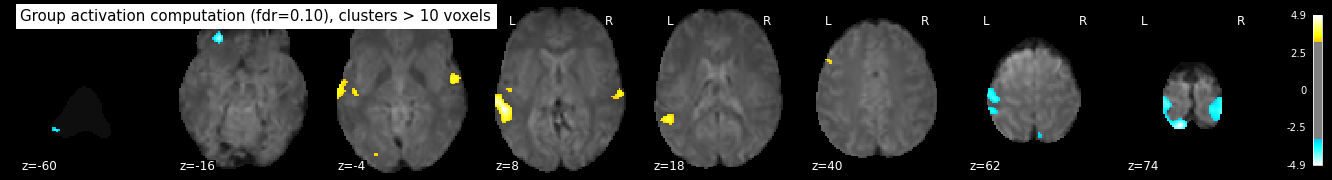

In [88]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Group activation computation (fdr=0.10), clusters > 10 voxels') 
    plt.show()

In [89]:
report_computation = make_glm_report(second_level_model_computation,
                         contrasts='intercept',
                         bg_img=mean_img
                         )

# Sentence Group Activity

In [90]:
second_level_model_sentences = second_level_model.fit(list_z_maps_sentences, design_matrix=design_matrix)

In [91]:
# Getting raw results (z_map_group_video), clean results (clean_map), and a thresold to plot the restults
z_map_group_sentences = second_level_model_sentences.compute_contrast(second_level_contrast=second_glm_contrast_intercept, output_type='z_score')

# <> Change type of threshold
clean_map, threshold = threshold_stats_img(z_map_group_sentences, alpha=.05, height_control='fdr', cluster_threshold=10)


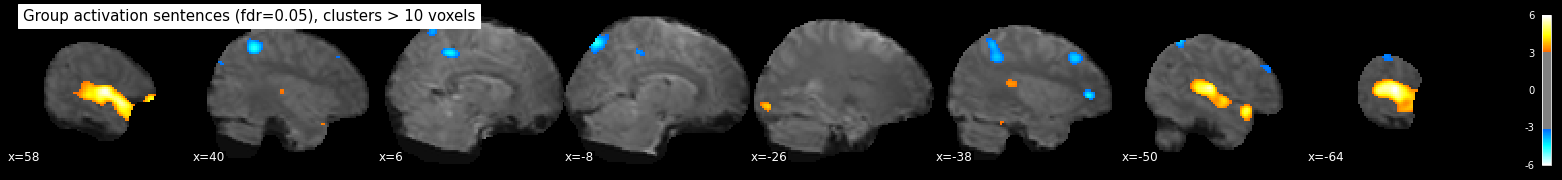

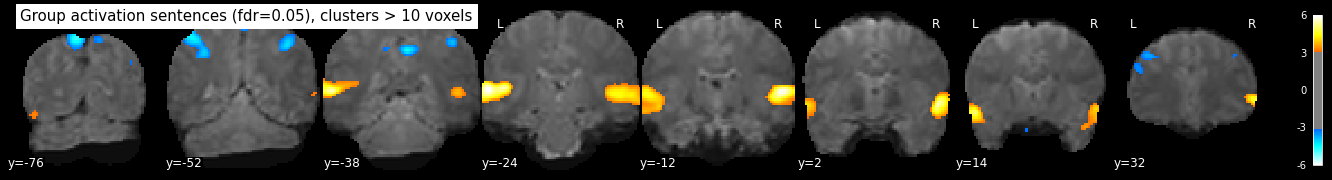

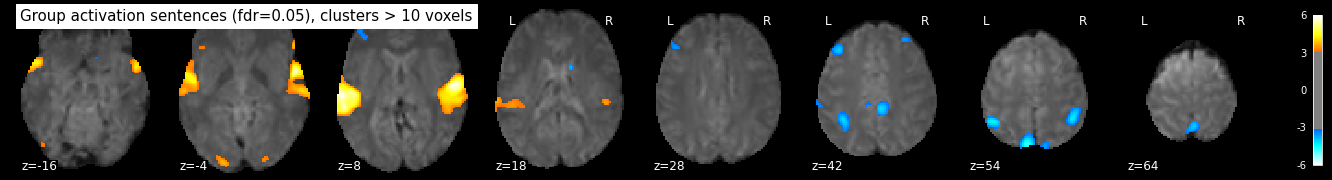

In [92]:
dim = ['x', 'y', 'z']

for x in range(3):
    
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode=dim[x], cut_coords=8, black_bg=True,
              title='Group activation sentences (fdr=0.05), clusters > 10 voxels') 
    plt.show()

In [93]:
report_sentences = make_glm_report(second_level_model_sentences,
                         contrasts='intercept',
                         bg_img=mean_img
                         )

In [94]:
report_audio

smoothing_fwhm,8.0
target_affine,NaN
target_shape,NaN


In [95]:
report_video

smoothing_fwhm,8.0
target_affine,NaN
target_shape,NaN


In [96]:
report_mov_right

smoothing_fwhm,8.0
target_affine,NaN
target_shape,NaN


In [97]:
report_mov_left

smoothing_fwhm,8.0
target_affine,NaN
target_shape,NaN


In [98]:
report_computation

smoothing_fwhm,8.0
target_affine,NaN
target_shape,NaN


In [99]:
report_sentences

smoothing_fwhm,8.0
target_affine,NaN
target_shape,NaN
